In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [50]:
vaccinations = pd.read_csv("owid-covid-data.csv")
vaccinations['date'] = pd.to_datetime(vaccinations['date'], format='%Y-%m-%d')

regions = pd.read_csv("vaccinationAnalysis/all.csv")

tweets = pd.read_csv("vaccination_all_tweets.csv")
sentiments = pd.read_csv("covid-19_vaccine_tweets_with_sentiment.csv")
all_tweet_data = pd.merge(sentiments, tweets, left_on = 'tweet_id', right_on = 'id')
all_tweet_data.rename(columns={'label': 'sentiment'}, inplace=True)

print(vaccinations.head(), regions.head(), all_tweet_data.head())

  iso_code continent     location       date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan 2020-02-24          1.0        1.0   
1      AFG      Asia  Afghanistan 2020-02-25          1.0        0.0   
2      AFG      Asia  Afghanistan 2020-02-26          1.0        0.0   
3      AFG      Asia  Afghanistan 2020-02-27          1.0        0.0   
4      AFG      Asia  Afghanistan 2020-02-28          1.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
0              NaN                597.

In [51]:
vax_info = vaccinations[['iso_code', 'location', 'people_vaccinated_per_hundred', 'continent']]
region_info = regions[['name', 'alpha-2', 'alpha-3', 'country-code', 'region', 'region-code']]
tweet_info = all_tweet_data[['id', 'user_location', 'user_followers', 'sentiment']]


In [52]:
vax_n = region_info['name']
vax_a2 = region_info['alpha-2']
vax_a3 = region_info['alpha-3']
vax_r = region_info['region']
def fixlocation(loc):
    loc = str(loc).split(", ")
    hit = False
    for i in range(len(vax_n)):
        for l in loc:
            if l == str(vax_n[i]):
                return str(vax_n[i])
            elif l == str(vax_a2[i]):
                return str(vax_n[i])
            elif l == str(vax_a3[i]):
                return str(vax_n[i])
            elif l == str(vax_r[i]):
                return str(vax_n[i])
    return loc[-1]

def categorizeNum(val):
    if val == 1:
        return "negative"
    elif val == 2:
        return "neutral"
    elif val == 3:
        return "positive"
    else:
        return "unsure"

In [53]:
tweet_info = tweet_info.dropna(how='any',axis=0) 
tweet_info['location'] = [fixlocation(loc) for loc in tweet_info['user_location']]
tweet_info = pd.merge(tweet_info, region_info, left_on='location', right_on='name', how='inner')
print(tweet_info.head())

                    id        user_location  user_followers  sentiment  \
0  1362165556091191296       Wisconsin, USA            3744          3   
1  1384834947110903808  North Carolina, USA             534          2   
2  1359713613087469568      Des Moines, USA             269          3   
3  1355007738003255296       Minnesota, USA              30          2   
4  1353930694267817984          Oregon, USA              23          2   

                   location                      name alpha-2 alpha-3  \
0  United States of America  United States of America      US     USA   
1  United States of America  United States of America      US     USA   
2  United States of America  United States of America      US     USA   
3  United States of America  United States of America      US     USA   
4  United States of America  United States of America      US     USA   

   country-code    region  region-code  
0           840  Americas         19.0  
1           840  Americas         

In [56]:
vax_n = region_info['name']
vax_a2 = region_info['alpha-2']
vax_a3 = region_info['alpha-3']
def fixloc(loc):
    for i in range(len(vax_n)):
            if loc == str(vax_n[i]):
                return str(vax_n[i])
            elif loc == str(vax_a2[i]):
                return str(vax_n[i])
            elif loc == str(vax_a3[i]):
                return str(vax_n[i])
            elif loc == str(vax_r[i]):
                return str(vax_n[i])
    return loc[-1]


In [57]:
vaax_info = vax_info.groupby('location').aggregate({'iso_code': 'max', 'people_vaccinated_per_hundred': 'max'})
vaax_info['location'] = [fixloc(loc) for loc in vaax_info['iso_code']]
print(set(vaax_info.index.values))
print(vaax_info.head())

{'Latvia', 'Malta', 'Ukraine', 'Cambodia', 'Turkmenistan', 'Madagascar', 'San Marino', 'Sint Maarten (Dutch part)', 'Vietnam', 'Guinea-Bissau', 'Senegal', 'Bulgaria', 'Lebanon', 'Togo', 'Pitcairn', 'Cayman Islands', 'Turks and Caicos Islands', 'China', 'Iraq', 'Cape Verde', 'Andorra', 'North America', 'Sweden', 'Northern Cyprus', 'Falkland Islands', 'Kiribati', 'Belize', 'Cuba', 'Seychelles', 'Myanmar', 'Wallis and Futuna', 'Montserrat', 'Burkina Faso', 'Taiwan', 'Liechtenstein', 'Niger', 'French Polynesia', 'Afghanistan', 'Ecuador', 'Oman', 'Isle of Man', 'Armenia', 'Congo', 'Egypt', 'Estonia', 'Oceania', 'World', 'United Kingdom', 'Kuwait', 'Nauru', 'Yemen', 'British Virgin Islands', 'Somalia', 'Guyana', 'Italy', 'Marshall Islands', 'Mongolia', 'Nepal', 'Singapore', 'United States', 'South Africa', 'Uzbekistan', 'Cameroon', 'Curacao', 'Palestine', 'Suriname', 'Peru', 'Qatar', 'Dominica', 'Eswatini', 'Spain', 'Trinidad and Tobago', 'Tuvalu', 'Gabon', 'Syria', 'Jamaica', 'Lesotho', 'Ne

In [86]:
import matplotlib.pyplot as plt
tweet_vax =pd.merge(tweet_info, vaax_info, left_on='alpha-3', right_on='iso_code', how="inner")
print(tweet_vax.head())
countries = tweet_vax.groupby('name').agg(tweet_count =('sentiment', 'count'), 
                                               region=('region', 'max'))
#print(countries[:len(countries)//2], countries[len(countries)//2:])
#display(countries[:len(countries)//2])
#display(countries[len(countries)//2:])
#regions = tweet_vax.groupby('region').agg(tweet_count =('sentiment', 'count'), 
                                               #region=('region', 'max'))
#print(regions)
#display(regions)
tweet_vax = tweet_vax.dropna(how='any',axis=0)


                    id        user_location  user_followers  sentiment  \
0  1362165556091191296       Wisconsin, USA            3744          3   
1  1384834947110903808  North Carolina, USA             534          2   
2  1359713613087469568      Des Moines, USA             269          3   
3  1355007738003255296       Minnesota, USA              30          2   
4  1353930694267817984          Oregon, USA              23          2   

                 location_x                      name alpha-2 alpha-3  \
0  United States of America  United States of America      US     USA   
1  United States of America  United States of America      US     USA   
2  United States of America  United States of America      US     USA   
3  United States of America  United States of America      US     USA   
4  United States of America  United States of America      US     USA   

   country-code    region  region-code iso_code  \
0           840  Americas         19.0      USA   
1           84

In [143]:
res_neu = tweet_vax[tweet_vax['sentiment'] == 2] 
res_pos = tweet_vax[tweet_vax['sentiment'] == 3] 
res_neg = tweet_vax[tweet_vax['sentiment'] == 1] 
rslt_df = pd.concat([res_neu.sample(n=100), pd.concat([res_pos, res_neg])])
rslt_df['sentiments'] = [categorizeNum(val) for val in rslt_df['sentiment']]
print(len(res_neu), len(res_pos), len(res_neg))

203 88 19


Model Score: 0.5748792270531401


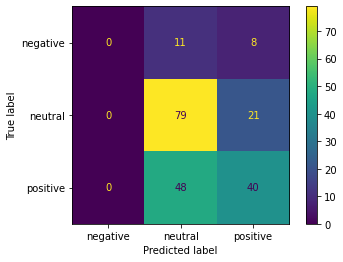

In [144]:
target = rslt_df['sentiments']

data = rslt_df[['people_vaccinated_per_hundred', 'user_followers', 'region-code']]

logistic_model = LogisticRegression()
logistic_model.fit(X=data, y=target)

rslt_df['predicted_outcome'] = logistic_model.predict(data)

q4_score = logistic_model.score(data, target)

plot_confusion_matrix(logistic_model, data, target)

print("Model Score:", q4_score)

plt.grid(False)

Model Score: 0.5652173913043478


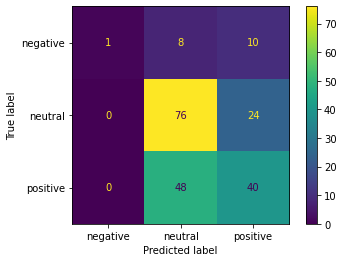

In [140]:

target = rslt_df['sentiments']

data = rslt_df[['people_vaccinated_per_hundred', 'user_followers', 'region-code']]

logistic_model = LogisticRegression()
logistic_model.fit(X=data, y=target)

rslt_df['predicted_outcome'] = logistic_model.predict(data)

q4_score = logistic_model.score(data, target)

plot_confusion_matrix(logistic_model, data, target)

print("Model Score:", q4_score)

plt.grid(False)

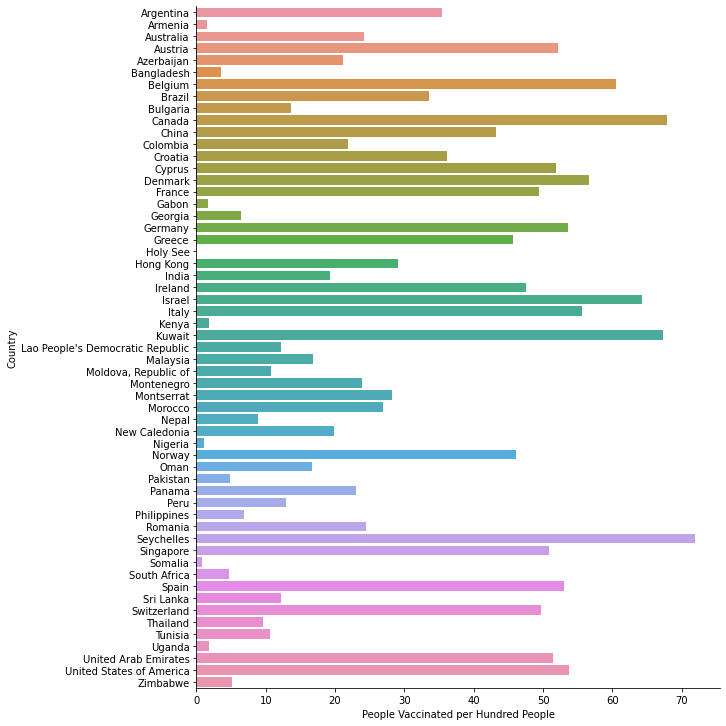

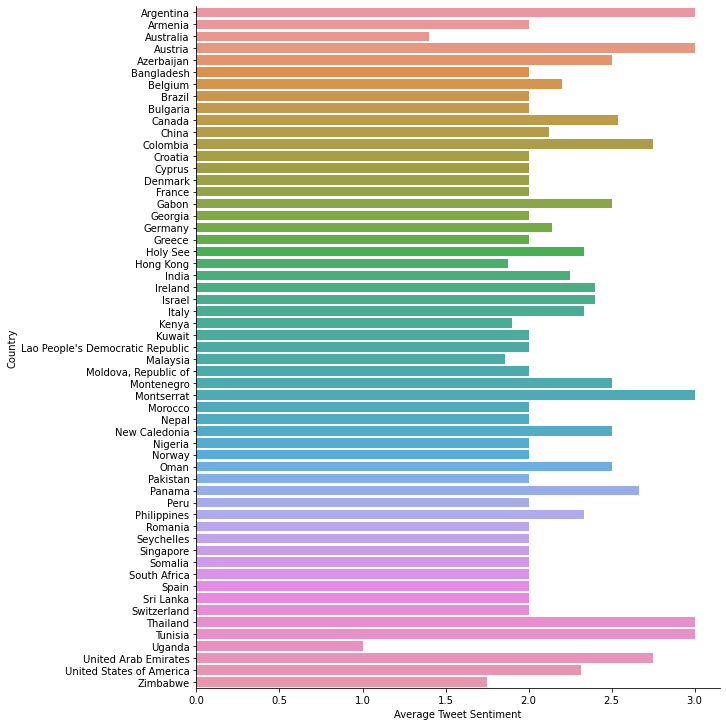

In [68]:
tvax = tweet_vax[['id', 'name', 'people_vaccinated_per_hundred', 'sentiment', 'region']]
vaxandtweet = tvax.groupby('name').aggregate({'sentiment': 'mean', 'people_vaccinated_per_hundred': 'max'})
vax1 = vaxandtweet[:len(vaxandtweet)//2]
vax2 = vaxandtweet[len(vaxandtweet)//2:]
#sns.catplot(data=vaxandtweet, x=vaxandtweet.index, y='people_vaccinated_per_hundred', kind='bar', aspect=10)
v = sns.catplot(data=vaxandtweet, y=vaxandtweet.index, x='people_vaccinated_per_hundred', kind='bar', aspect=1, height = 10, orient = "h")
v.set(xlabel='People Vaccinated per Hundred People', ylabel='Country')
#sns.catplot(data=vax2, x=vax2.index, y='people_vaccinated_per_hundred', kind='bar', aspect=10)
#sns.catplot(data=vaxandtweet, x=vaxandtweet.index, y='sentiment', kind='bar', aspect=10)
s = sns.catplot(data=vaxandtweet, y=vaxandtweet.index, x='sentiment', kind='bar', aspect=1, height = 10, orient = "h")
s.set(xlabel='Average Tweet Sentiment', ylabel='Country')
#sns.catplot(data=vax2, x=vax2.index, y='sentiment', kind='bar', aspect=10)
s.savefig('vaxByCountry.png', dpi=300)
v.savefig('sentByCountry.png', dpi=300)

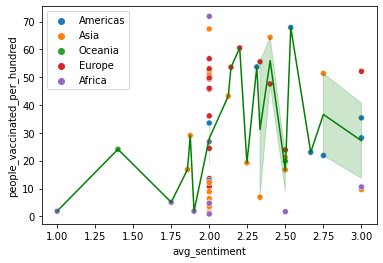

In [146]:
serDf = tweet_vax.groupby('name').agg(avg_sentiment =('sentiment', 'mean'), people_vaccinated_per_hundred=('people_vaccinated_per_hundred', 'max'),
                                               region=('region', 'max'))

p1 = sns.scatterplot(x=serDf['avg_sentiment'], y = serDf['people_vaccinated_per_hundred'], hue=serDf['region'])
p2 = sns.lineplot(data=serDf, x=serDf['avg_sentiment'], y = serDf['people_vaccinated_per_hundred'], color='g')

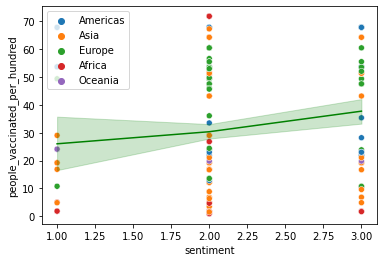

In [148]:
p3 = sns.scatterplot(x=tweet_vax['sentiment'], y = tweet_vax['people_vaccinated_per_hundred'], hue=tweet_vax['region'])
p4 = sns.lineplot(data=tweet_vax, x=tweet_vax['sentiment'], y = tweet_vax['people_vaccinated_per_hundred'], color='g')

In [150]:
grouped = tweet_vax.groupby('iso_code').agg({'sentiment':'mean', 'people_vaccinated_per_hundred':'mean'})
correlation_matrix = np.corrcoef(grouped['sentiment'].values, grouped['people_vaccinated_per_hundred'].values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

0.022079101069505103


/Users/juliaziaee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/juliaziaee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/juliaziaee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/juliaziaee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/juliaziaee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


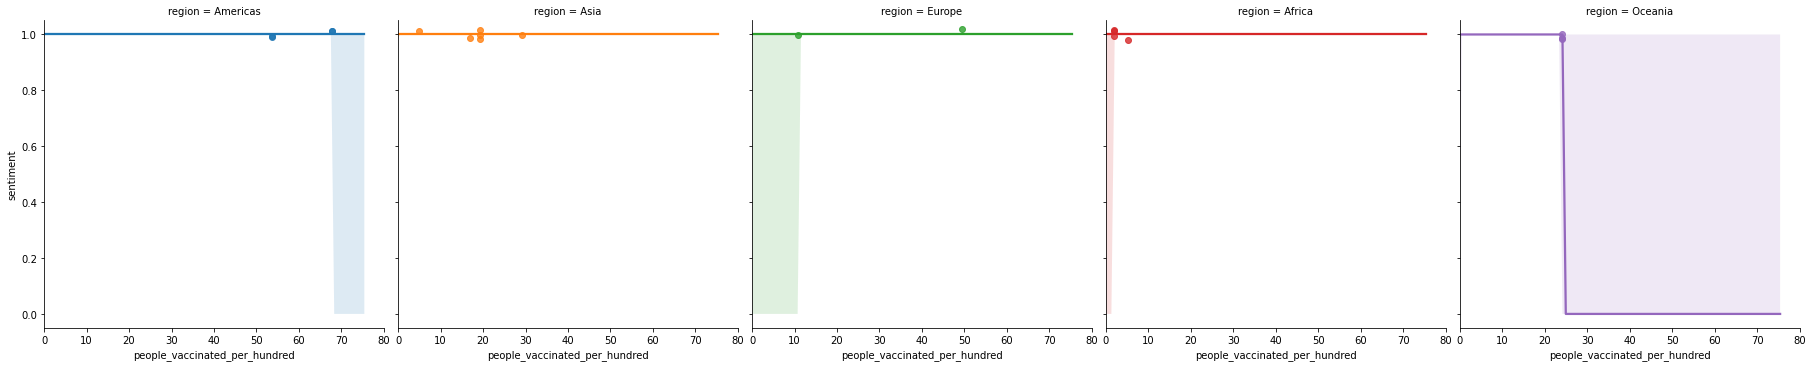

In [151]:


# Show the survival probability as a function of age and sex
g = sns.lmplot(x="people_vaccinated_per_hundred", y="sentiment", col="region", hue="name", data=tweet_vax, 
               fit_reg = True, y_jitter=.02, logistic=True, truncate=False)
g.set(xlim=(0, 80), ylim=(-.05, 1.05))